In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd
import pickle
import random
from sklearn.model_selection import train_test_split
import skimage.io
import skimage
%load_ext tensorboard
# from google.colab.patches import cv2_imshow

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
epochs = 300
batch_size = 24
ImgDir = "Cube/"

features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")

print(len(features), len(labels))

4000 4000


In [4]:
# from skimage.transform import resize
# import numpy as np
# import imgaug.augmenters as iaa
# import imgaug as ia

# images_fold = os.listdir(f"{ImgDir}features/")
# segmaps_fold = os.listdir(f"{ImgDir}labels/")
# print(images_fold[0])
# images = []
# segmaps = []
# for i, s in zip(images_fold, segmaps_fold):
#     x = skimage.io.imread(f"{ImgDir}features/{i}")
#     y = skimage.io.imread(f"{ImgDir}labels/{s}")
# #     print(x[100:120,100:120,0])
#     x = np.uint8(resize(x,(IMG_HEIGHT, IMG_WIDTH), preserve_range=True))
#     y = np.uint8(resize(y,(IMG_HEIGHT, IMG_WIDTH), preserve_range=True))
# #     print(x[100:120,100:120,0])
    
    
#     images.append(x)
#     segmaps.append(y)
    
# images = np.array(images)
# segmaps = np.array(segmaps)


# sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# seq = iaa.Sequential(
#     [
#         # apply the following augmenters to most images
#         iaa.Fliplr(0.5), # horizontally flip 50% of all images
#         iaa.Flipud(0.2), # vertically flip 20% of all images
#         # crop images by -5% to 10% of their height/width
#         sometimes(iaa.CropAndPad(
#             percent=(-0.05, 0.1),
#             pad_mode=ia.ALL,
#             pad_cval=(0, 255)
#         )),
#         sometimes(iaa.Affine(
#             scale={"x": (1, 1.4), "y": (1, 1.4)}, # scale images to 80-120% of their size, individually per axis
# #             translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
# #             rotate=(-45, 45), # rotate by -45 to +45 degrees
# #             shear=(-16, 16), # shear by -16 to +16 degrees
#             order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#             cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#             mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         )),
#         # execute 0 to 5 of the following (less important) augmenters per image
#         # don't execute all of them, as that would often be way too strong
#         iaa.SomeOf((0, 5),
#             [
#                 sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#                 iaa.OneOf([
#                     iaa.GaussianBlur((0, 8.0)), # blur images with a sigma between 0 and 3.0
# #                     iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
# #                     iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
#                 ]),
#                 iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
#                 iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
#                 # search either for all edges or for directed edges,
#                 # blend the result with the original image using a blobby mask
#                 iaa.SimplexNoiseAlpha(iaa.OneOf([
#                     iaa.EdgeDetect(alpha=(0.5, 1.0)),
#                     iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
#                 ])),
#                 iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
#                 iaa.OneOf([
#                     iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
#                     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
#                 ]),
#                 iaa.Invert(0.05, per_channel=True), # invert color channels
#                 iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                 iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
#                 # either change the brightness of the whole image (sometimes
#                 # per channel) or change the brightness of subareas
#                 iaa.OneOf([
#                     iaa.Multiply((0.5, 1.5), per_channel=0.5),
#                     iaa.FrequencyNoiseAlpha(
#                         exponent=(-4, 0),
#                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                         second=iaa.LinearContrast((0.5, 2.0))
#                     )
#                 ]),
#                 iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                 iaa.Grayscale(alpha=(0.0, 1.0)),
#                 sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                 sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                 sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
#             ],
#             random_order=True
#         )
#     ],
#     random_order=True
# )

# a = 0
# for i in range(10):
#     tmp = seq(images=images, segmentation_maps=segmaps)
#     for im, tg in zip(tmp[0], tmp[1]):
        
#         skimage.io.imsave((ImgDir + 'features/' + str(a) +'.png'), im)
#         skimage.io.imsave((ImgDir + 'labels/' + str(a) +'_y.png'), tg)
#         a += 1
#         print(i)
    
    
# # images_aug, segmaps_aug = seq(images=images, segmentation_maps=segmaps)

# # features = os.listdir(f"{ImgDir}features/")
# # labels = os.listdir(f"{ImgDir}labels/")

# # print(len(features), len(labels))

In [5]:
# print(len(images_aug))

# numb = 0
# plt.subplot(1,2,1)
# plt.imshow(images_aug[numb])
# plt.subplot(1,2,2)
# plt.imshow(segmaps_aug[numb])

In [6]:
features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")
image_for_test = os.listdir(f"{ImgDir}image_for_test/")

print(len(features), len(labels), len(image_for_test))

4000 4000 19


In [7]:
X = features
y = labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=1)
print(X_train[0])
print(len(X_train), len(X_val), len(X_test))

# print(X_train.sum())

SampleScene_2667_img.png
2800 1020 180


In [9]:
from skimage.transform import resize
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    elif choice == "test":
        X = X_test
        y = y_test
    elif choice == "i_test":
        X = image_for_test
        y = y_test
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            
            if choice == "i_test":
                x_rand = random.choice(X)

                x_path = f"{ImgDir}image_for_test/{x_rand}"
                
                x = skimage.io.imread(x_path)

                x = np.uint8(resize(x,(IMG_HEIGHT, IMG_WIDTH), preserve_range=True))

                x = x / 255.

                x_batch.append(x)
                y_batch.append(x)
                
            else:
                x_rand = random.choice(X)
    #             for real
    #             y_rand = x_rand[:-4]+"_y.png"
    #             fro synt
                y_rand = x_rand[:-8]+"_layer.png"

                x_path = f"{ImgDir}features/{x_rand}"
                y_path = f"{ImgDir}labels/{y_rand}"

    #             x = cv2.imread(x_path)
    #             y = cv2.imread(y_path)
                x = skimage.io.imread(x_path)
                y = skimage.io.imread(y_path)
                y = y[:,:,0]
                try:
                    x = np.uint8(resize(x,(IMG_HEIGHT, IMG_WIDTH), preserve_range=True))
                except:
                    
                    print('x_path:',x_path)
                    
                y = np.uint8(resize(y,(IMG_HEIGHT, IMG_WIDTH), preserve_range=True))

                x = x / 255.
                y = y / 255.
                y[y > 0.5] = 1
                y[y <= 0.5] = 0
#                 y = np.where(y > 0, 255, 0)[:,:,0]
                y = np.expand_dims(y,axis=2)
                x_batch.append(x)
                y_batch.append(y)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

    for x, y in keras_generator_train_val_test(2, choice="train"):
        break

    print(x.shape, y['seg'].shape)

In [10]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
#     bat = BatchNormalization()(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'}

    metrics = {'seg': ['acc','mse']
                }
    model.compile(optimizer="adam", loss=losses, metrics=metrics)

    return model

In [11]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_purple_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_purple_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="i_test"):
            break
        p = np.reshape(x_test[0], (1, IMG_HEIGHT, IMG_WIDTH, 3))
        prediction = self.model.predict(p)
        print(epoch, 'epoch')
# IMG_HEIGHT = 384
# IMG_WIDTH = 384
        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        skimage.io.imsave(x_img, np.uint8(x_test[0] * 255.))
        skimage.io.imsave(y_img, np.uint8(y_test['seg'][0] * 255.))
        skimage.io.imsave(predicted_img, np.uint8(prediction[0] * 255.))

In [12]:
model = get_model()
# model = tf.keras.models.load_model('saved_model/op_norm_model')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D) 

In [13]:

model_name = "models/"+"Unet_or_purple_backgroun.h5"



In [15]:
import warnings
warnings.filterwarnings('ignore')
modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
#                                   save_best_only=True
                                 )

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


callback_list = [
#     modelcheckpoint,
    lr_callback,
    MyCustomCallback(),
#                  tensorboard_callback
                ]
print(IMG_HEIGHT, IMG_WIDTH)
batch_size = 20
steps_per_epoch = len(X_train) // batch_size -1
validation_steps = len(X_val) // batch_size -1

print('batch_size:',batch_size)
print('steps_per_epoch:',steps_per_epoch)
print('validation_steps:',validation_steps)
epochs = 100
with tf.device("/device:GPU:0"):
    history = model.fit(
        keras_generator_train_val_test(batch_size, choice="train"),
        validation_data = keras_generator_train_val_test(batch_size, choice="val"),
        validation_steps=validation_steps,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1, 
        shuffle=True,
        callbacks = callback_list,
    )

256 256
batch_size: 20
steps_per_epoch: 139
validation_steps: 50
intermediate_results_purple_background directory already exist
Training: epoch None begins at 00:54:58.356299
Epoch 1/100
 50/139 [=========>....................] - ETA: 1:43 - loss: 0.0822 - acc: 0.9720 - mean_squared_error: 0.0226Training: epoch 0 ends at 00:58:55.536708
0 epoch
139/139 [==============================] - 278s 2s/step - loss: 0.1527 - acc: 0.9549 - mean_squared_error: 0.0374 - val_loss: 0.0822 - val_acc: 0.9720 - val_mean_squared_error: 0.0226
Epoch 2/100
 50/139 [=========>....................] - ETA: 1:36 - loss: 0.0641 - acc: 0.9798 - mean_squared_error: 0.0160Training: epoch 1 ends at 01:02:45.028992
1 epoch
139/139 [==============================] - 228s 2s/step - loss: 0.0344 - acc: 0.9877 - mean_squared_error: 0.0094 - val_loss: 0.0641 - val_acc: 0.9798 - val_mean_squared_error: 0.0160
Epoch 3/100
 50/139 [=========>....................] - ETA: 1:29 - loss: 0.0471 - acc: 0.9871 - mean_squared_erro

KeyboardInterrupt: 

In [73]:
a = next(keras_generator_train_val_test(batch_size, choice="train"))

In [63]:
v = model.predict(next(keras_generator_train_val_test(batch_size, choice="train"))[0])

In [68]:
# plt.imshow(v[0])

In [67]:
c = a[1]['seg'][0]
a[0][0]
# plt.imshow(c)
# np.unique(c)
c
# plt.imshow(c)
# np.where(c>0,1.,0)

In [23]:
# %tensorboard --logdir logs/fit

In [22]:
# %tensorboard --logdir logs

In [14]:
from skimage.transform import resize

from skimage.feature import canny

from scipy import ndimage as ndi
from skimage.segmentation import watershed
# edges = canny(coins/255.)
from skimage.filters import sobel

def show_pred(files):
    kol = len(files)
    plt.figure(figsize=(22,kol*6))
    
    
    for i in range(kol):
        image = skimage.io.imread(files[i])
        i += 1
        s = np.array([resize(image,(IMG_HEIGHT, IMG_WIDTH))])
        if s.max() > 1:
            s = s / 255.0
            
        im = skimage.img_as_ubyte(s[0])
#         mask = skimage.img_as_ubyte(model.predict(s)[0])
#         print(model.predict(s)[0][:,:,0].shape)
        m = model.predict(s)[0][:,:,0]*255.
        mask  = canny(m*255.)
#         mask = ndi.binary_fill_holes(mask)
        
#         markers = np.zeros_like(m)
#         elevation_map = sobel(m)
#         markers[m < 140] = 1
#         markers[m > 140] = 2
#         print(np.unique(m))
        
#         re_mask = watershed(elevation_map, markers)
#         re_mask = skimage.img_as_ubyte(model.predict(s)[0]) 
        re_mask = model.predict(s)[0]
        
        plt.subplot(kol,3, (i-1) * 3 + 1)
        plt.imshow(im)

        plt.subplot(kol,3,(i-1) * 3 + 2)
        plt.imshow(m)

        plt.subplot(kol,3,(i-1) * 3 + 3)
#         plt.imshow(re_mask[:,:, 0])
        plt.imshow(re_mask)

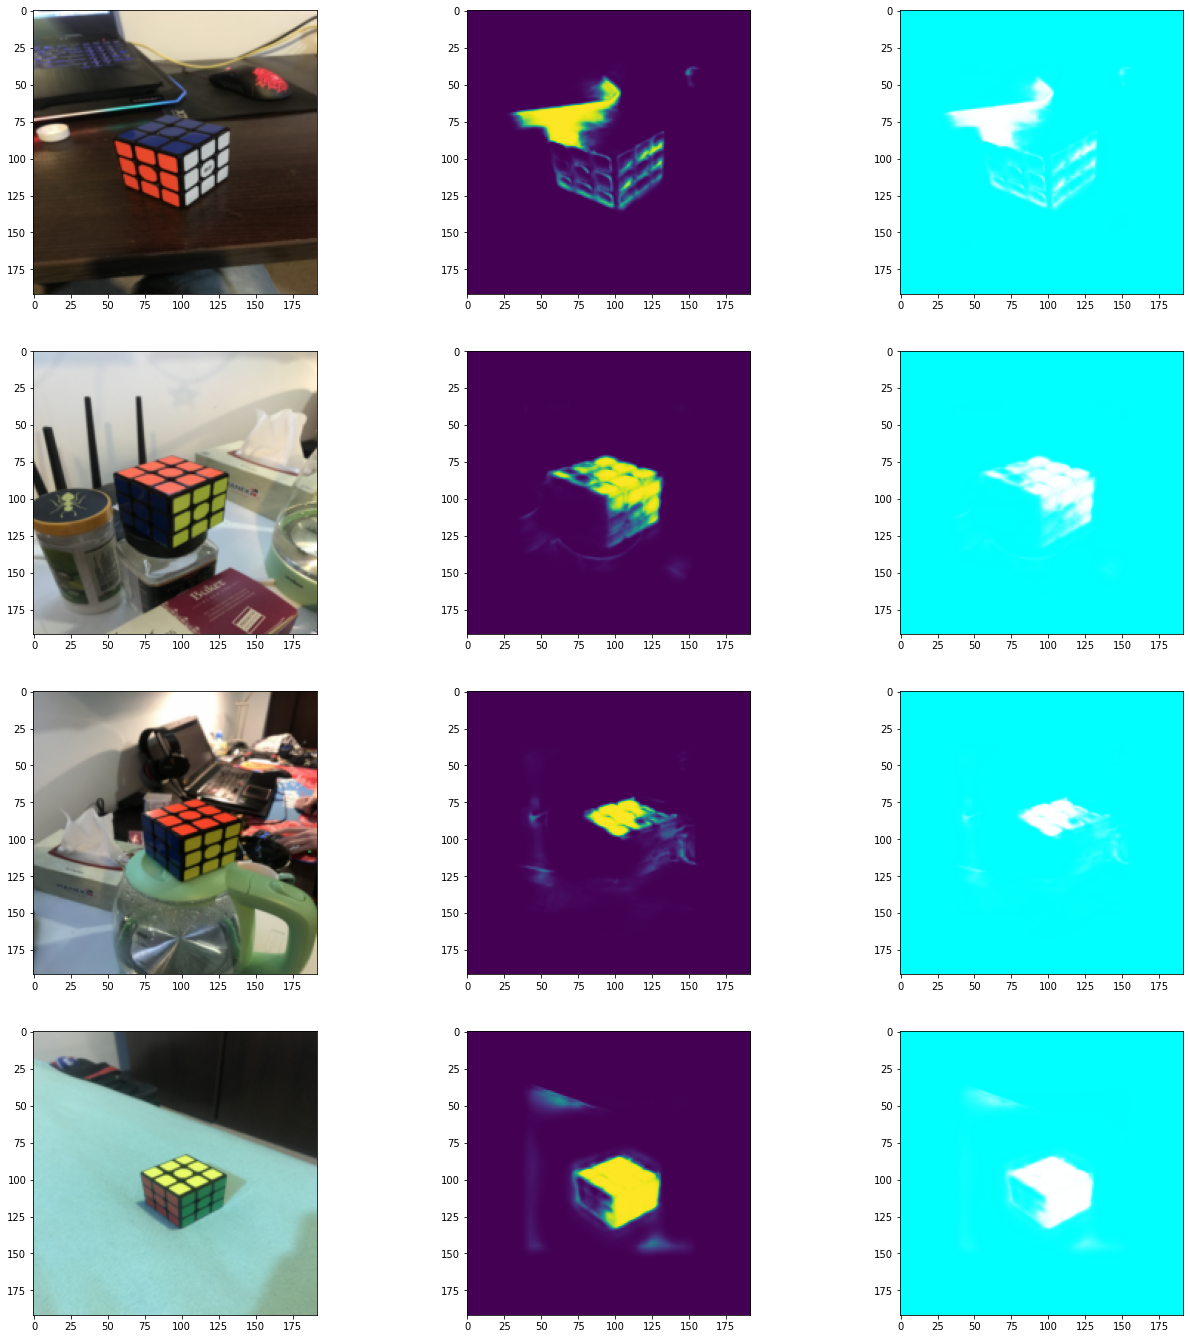

In [15]:
import glob
files = glob.glob('Cube/image_for_test/*')
# print(len(files))

cut_files = files[1:5]
show_pred(cut_files)

In [18]:
image = skimage.io.imread(files[0])
s = np.array([resize(image,(IMG_HEIGHT, IMG_WIDTH))])
if s.max() > 1:
    s = s / 255.0

(128, 3)

In [29]:
model.save('test_model_8')

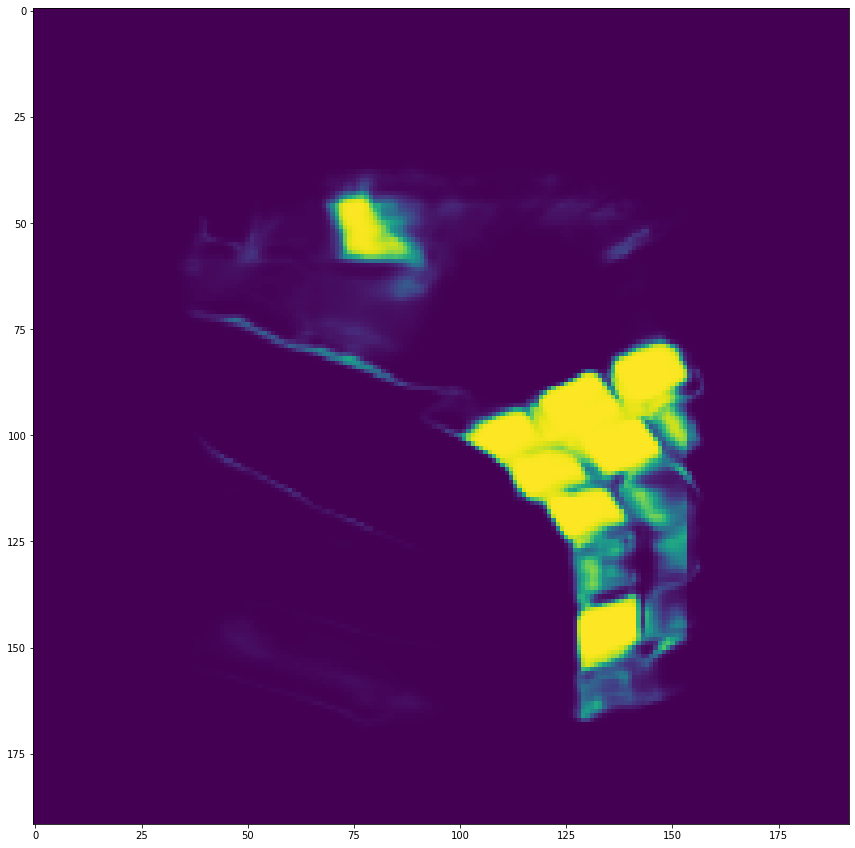

In [29]:
a = (model.predict(s)[0][:,:,0]*255).astype(int)
plt.imshow(a)

In [14]:
import glob
from scipy.special import softmax, log_softmax
files = glob.glob('Cube/labels/*')
files[1]


image = skimage.io.imread(files[4])
s = image[:,:,0]
image.shape
# s = np.array([resize(image,(IMG_HEIGHT, IMG_WIDTH))])
# s
# if s.max() > 1:
#     s = s / 255.0

# m = model.predict(s)[0]
# plt.imshow(image)


(512, 512, 3)

In [15]:
s = image[:,:,0]

In [16]:
# %%time
shl0 = np.nonzero(np.sum(s,axis=0))[0]
shl1 = np.nonzero(np.sum(s,axis=1))[0]

xmin, xmax = shl0[0], shl0[-1]

ymin,ymax  = shl1[0], shl1[-1]

print(xmin,ymax, xmax,ymin)

161 365 392 135


In [21]:
# image = cv2.imread(s)
import cv2
   
# Window name in which image is displayed
window_name = 'Image'
  
end_point = (xmin,ymax)
  
# Ending coordinate, here (220, 220)
# represents the bottom right corner of rectangle
start_point = (xmax,ymin)
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image = cv2.rectangle(image, start_point, end_point, color, thickness)
  
# Displaying the image 
cv2.imshow(window_name, image) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [181]:
# log_softmax((m*255))
# -log_softmax((m*255)).astype(int)

In [1]:
import sys
import numpy as np
import cv2 as cv

hsv_min = np.array((0, 54, 5), np.uint8)
hsv_max = np.array((187, 255, 253), np.uint8)


img = softmax(m*255)

hsv = cv.cvtColor( img, cv.COLOR_BGR2HSV ) # меняем цветовую модель с BGR на HSV
thresh = cv.inRange( hsv, hsv_min, hsv_max ) # применяем цветовой фильтр
contours0, hierarchy = cv.findContours( thresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# перебираем все найденные контуры в цикле
for cnt in contours0:
    rect = cv.minAreaRect(cnt) # пытаемся вписать прямоугольник
    box = cv.boxPoints(rect) # поиск четырех вершин прямоугольника
    box = np.int0(box) # округление координат
    cv.drawContours(img,[box],0,(255,0,0),2) # рисуем прямоугольник
    
plt.imshow(img)

#     cv.imshow('contours', img) # вывод обработанного кадра в окно

#     cv.waitKey()
#     cv.destroyAllWindows()

In [65]:
(m[0][0][0])*255

4.669696775731608e-18

In [50]:
import sys
import numpy as np
import cv2 as cv2



# параметры цветового фильтра
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)

if __name__ == '__main__':
    print(__doc__)

#     fn = 'image.jpg' # путь к файлу с картинкой
#     img = cv2.imread(m)

    hsv = cv2.cvtColor( m, cv2.COLOR_BGR2HSV ) # меняем цветовую модель с BGR на HSV 
    thresh = cv2.inRange( hsv, hsv_min, hsv_max ) # применяем цветовой фильтр
    # ищем контуры и складируем их в переменную contours
    contours, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # отображаем контуры поверх изображения
    cv.drawContours( m, contours, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1 )
    cv.imshow('contours', m) # выводим итоговое изображение в окно

    cv.waitKey()
    cv.destroyAllWindows()

Automatically created module for IPython interactive environment


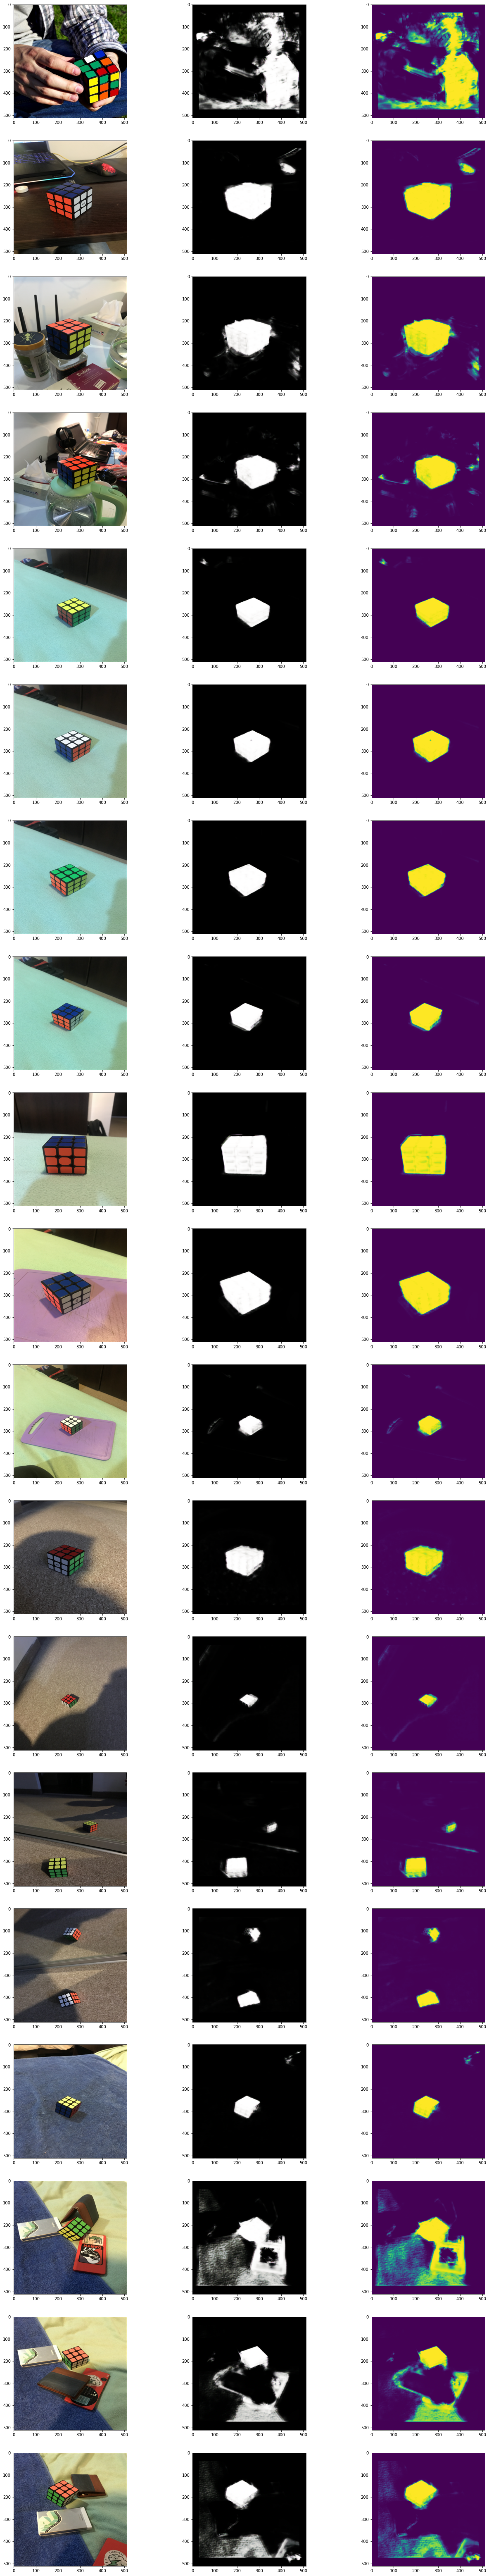

In [31]:
import glob
files = glob.glob('Cube/image_for_test/*')
show_pred(files)

In [17]:
# from skimage.transform import resize
# image_0 = skimage.io.imread('Cube/features/SampleScene_170_img.png')
# image_1 = skimage.io.imread('Cube/1247683.png')
# image_2 = skimage.io.imread('Cube/IMG_8281.JPG')
# image_3 = skimage.io.imread('BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp')
# images = [image_0, image_1,image_2,image_3]
# show_pred(images)

In [239]:
model.save('saved_model/real_norm_model256x256')

INFO:tensorflow:Assets written to: saved_model/real_norm_model256x256\assets


In [19]:
# pip install jupyter-resource-usage